In [65]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [66]:
def calculate_wacc(tax_rate = 0.35, unlevered_beta = 0.69, 
              risk_free_rate = 0.0304, market_return = 0.115, 
              interest_rate = 0.09, weight_debt = 0.2757, 
              liquidity_premium = 0.05, unsys_risk_adj = (1/0.3053-1)):

    weight_equity = 1 - weight_debt
    mrp = market_return - risk_free_rate
    levered_beta = unlevered_beta * (1 + (1 - tax_rate) * weight_debt)

    cost_of_equity = risk_free_rate + unlevered_beta * mrp
    financial_risk_premium = (levered_beta - unlevered_beta) * mrp
    levered_cost_of_equity = cost_of_equity + financial_risk_premium
    levered_cost_of_equity_liq = levered_cost_of_equity + liquidity_premium
    
    unsys_risk_premium = unsys_risk_adj * levered_beta * mrp

    tcoe = levered_cost_of_equity_liq + unsys_risk_premium
    wacc = tcoe * weight_equity + interest_rate * weight_debt * (1 - tax_rate)

    # print(f"Cost of Equity: {cost_of_equity}")
    # print(f"Financial Risk Premium: {financial_risk_premium}")
    # print(f"Levered Cost of Equity: {levered_cost_of_equity}")
    # print(f"Levered Cost of Equity with Liquidity Premium: {levered_cost_of_equity_liq}")
    # print(f"Unsystematic Risk Premium: {unsys_risk_premium}")
    # print(f"Total Cost of Equity: {tcoe}")
    # print(f"Weighted Average Cost of Capital: {wacc}")

    return wacc

In [126]:

# corr_with_market = 0.3053
# debt_to_equity = 0.2757
# weight_debt = 0.2757
# weight_equity = 1 - weight_debt


def calculate_npv(tax_rate = 0.35, investments = 18100, facility_costs = 16800,
                  labor_costs = 110240, revenues = 386100, inflation_rate = 0.04,
                  starting_cash = 27651.75,unlevered_beta = 0.69, risk_free_rate = 0.0304,
                  market_return = 0.115, liquidity_premium = 0.05, interest_rate = 0.09, 
                  cost_factor = 0.63, revenue_growth = 0.04):
    

    equity = starting_cash
    cum_wacc = 1
    npv = -1*starting_cash

    macrs = [0.2, 0.32, 0.192, 0.1152, 0.1152, 0.0576, 0, 0, 0, 0, 0]
    outstanding_principle = [10525.45, 8780.02, 6870.85, 4782.58, 2498.43, 0, 0, 0, 0, 0, 0]
    interest_payment = [876.46, 712.72, 533.63, 337.74, 123.47, 0, 0, 0, 0, 0, 0]
    principal_payment = [1745.44, 1909.17, 2088.26, 2284.16, 2498.43, 0, 0, 0, 0, 0, 0]

    for i in range(10):
        operating_costs = revenues * cost_factor
        depreciation = macrs[i] * investments
        loan_repayment = principal_payment[i] + interest_payment[i]
        ebit = revenues - operating_costs - labor_costs - facility_costs - depreciation
        ebt = ebit - loan_repayment
        net_income = ebt * (1-tax_rate)

        # Update the cash flow
        ending_cash = starting_cash
        ending_cash += net_income
        ending_cash += depreciation
        ending_cash -= investments if i == 0 else 0
        ending_cash += 10525.45 if i == 0 else 0 # Cash in from Financing

        # print(f'Net Income for year {i}: {round(net_income, 2)}')
        # print(f'Starting Cash for year {i}: {round(starting_cash, 2)}')
        # print(f'Ending Cash for year {i}: {round(ending_cash, 2)}')

        # Update the costs and revenues for next year
        facility_costs *= (1 + inflation_rate) 
        labor_costs *= (1 + inflation_rate)
        revenues *= (1 + revenue_growth)
        
        # Calculate Payout
        cash_buffer = 0.05*(1+inflation_rate)*revenues
        payout = ending_cash - cash_buffer
        starting_cash = ending_cash - payout

        equity = equity + net_income - payout
        w_equity = equity / (equity + outstanding_principle[i+1])
        w_debt = 1 - w_equity

        # print(f'Revenues for year {i+1}: {round(revenues, 2)}')
        # print(f'Starting Cash for year {i+1}: {round(starting_cash, 2)}')
        # print(f'Payout for year {i}: {round(payout, 2)}')
        # print(f'Equity for year {i}: {round(equity, 2)}')
        # print(f'Debt for year {i}: {round(outstanding_principle[i], 2)}')
        # print(f'Weight of Debt for year {i}: {round(w_debt, 4)}')

        # Calculate WACC
        wacc = calculate_wacc(tax_rate = tax_rate, unlevered_beta = unlevered_beta, 
              risk_free_rate = risk_free_rate, market_return = market_return, 
              interest_rate = interest_rate, weight_debt = w_debt, 
              liquidity_premium = liquidity_premium, unsys_risk_adj = (1/0.3053-1))
        
        cum_wacc /= (1+wacc)
        npv += payout*cum_wacc

        # print(f'WACC for year {i}: {round(wacc, 4)}')
        # print(f'Cumulative WACC for year {i}: {round(cum_wacc, 4)}')
        # print(f'NPV for year {i}: {round(npv, 2)}')

        if i == 9:
            tv = payout * (1 + inflation_rate) / (wacc - inflation_rate)
            tv *= cum_wacc
            # print(f'NPV without Terminal Value: {round(npv, 2)}')
            # print(f'NPV Terminal Value: {round(tv, 2)}')
            # print(f'NPV with Terminal Value: {round(npv+tv, 2)}')
            
            return (np.round(npv, 2), np.round(tv, 2), np.round(npv+tv, 2))


In [68]:
# calculate_npv(market_return=0.1730625)

15000.23


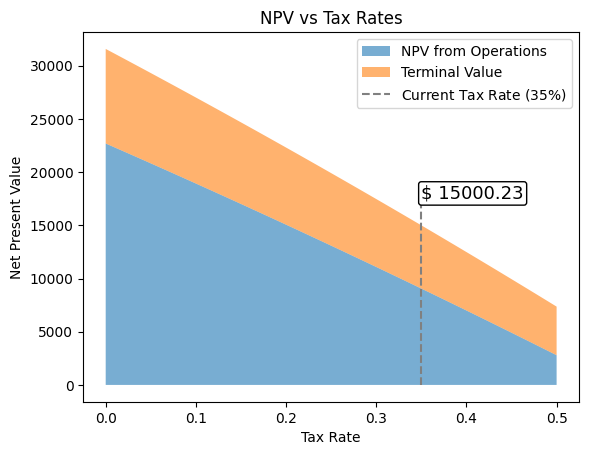

In [127]:
calculate_npvs = np.vectorize(calculate_npv)
tax_rates = np.linspace(0, 0.5, 100)
npvs = calculate_npvs(tax_rate=tax_rates)

# Calculate the stacked values
operations_npv = npvs[0]
terminal_value = npvs[1]

# Find the index corresponding to x=0.35
index_035 = 0.35
total_npv_035 = calculate_npv(tax_rate=0.35)[2]
print(total_npv_035)

index_break_even = 0.1730625

# Plot the stacked areas
plt.fill_between(tax_rates, 0, operations_npv, label='NPV from Operations', alpha=0.6)
plt.fill_between(tax_rates, operations_npv, operations_npv + terminal_value, label='Terminal Value', alpha=0.6)

# Add a vertical line at x=0.35
plt.vlines(x=0.35, ymin=0, ymax=total_npv_035*1.2, color='grey', linestyle='--', label='Current Tax Rate ($35\%$)')

# Add NPV at current tax rate value label.
plt.text(
    0.35,
    total_npv_035 * 1.2,
    r"$ " + str(total_npv_035),
    fontsize=13,
    va="center",
    bbox=dict(
        facecolor="white",
        edgecolor="black",
        boxstyle="round",
        pad=0.15
    ),
    zorder=10 # to make sure the text is on top
)

# Adding labels and title
plt.xlabel('Tax Rate')
plt.ylabel('Net Present Value')
plt.title('NPV vs Tax Rates')
plt.legend()

# Show plot
plt.show()


15000.23


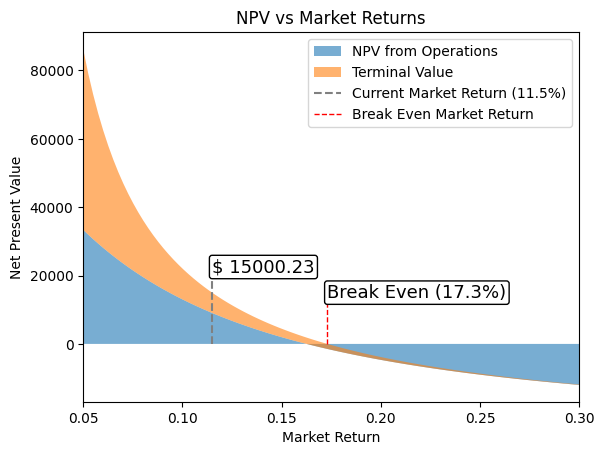

In [120]:
calculate_npvs = np.vectorize(calculate_npv)
market_returns = np.linspace(0.05, 0.3, 100)
npvs = calculate_npvs(market_return=market_returns)

# Calculate the stacked values
operations_npv = npvs[0]
terminal_value = npvs[1]

# Specific market return value at 0.115
total_npv_035 = calculate_npv(market_return=0.115)[2]
print(total_npv_035)

# Plot the stacked areas using market_returns instead of tax_rates
plt.fill_between(market_returns, 0, operations_npv, label='NPV from Operations', alpha=0.6)
plt.fill_between(market_returns, operations_npv, operations_npv + terminal_value, label='Terminal Value', alpha=0.6)

# Add a vertical line at market_return=0.115
plt.vlines(x=0.115, ymin=0, ymax=total_npv_035 * 1.5, color='grey', linestyle='--', label='Current Market Return (11.5%)')
plt.vlines(x=0.1730625, ymin=0, ymax=total_npv_035, color='red', linestyle='--', label='Break Even Market Return', linewidth=1)


# Add NPV at current market return value label
plt.text(
    0.115,
    total_npv_035 * 1.5,
    r"$ " + str(total_npv_035),
    fontsize=13,
    va="center",
    bbox=dict(
        facecolor="white",
        edgecolor="black",
        boxstyle="round",
        pad=0.15
    ),
    zorder=10  # to make sure the text is on top
)

plt.text(
    0.1730625,
    total_npv_035,
    "Break Even (17.3%)",
    fontsize=13,
    va="center",
    bbox=dict(
        facecolor="white",
        edgecolor="black",
        boxstyle="round",
        pad=0.15
    ),
    zorder=10 # to make sure the text is on top
)

# Adding labels and title
plt.xlabel('Market Return')
plt.ylabel('Net Present Value')
plt.title('NPV vs Market Returns')
plt.legend()

# Set the x-axis limits to match the market_returns range
plt.xlim(0.05, 0.3)

# Show plot
plt.show()



15000.23


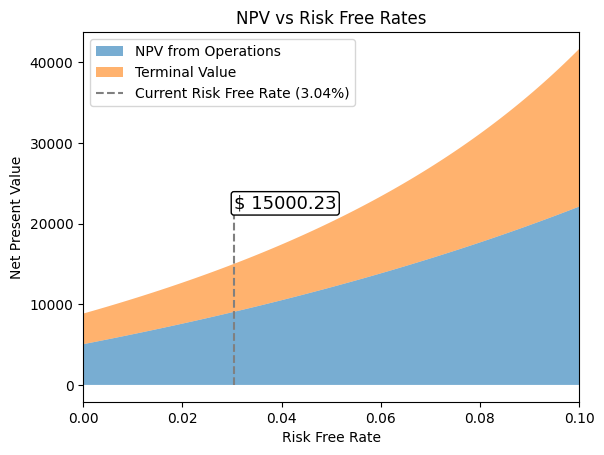

In [108]:
calculate_npvs = np.vectorize(calculate_npv)
risk_free_rates = np.linspace(0, 0.1, 100)
npvs = calculate_npvs(risk_free_rate=risk_free_rates)

# Calculate the stacked values
operations_npv = npvs[0]
terminal_value = npvs[1]

# Specific risk free rate value at 0.0304
total_npv_035 = calculate_npv(risk_free_rate=0.0304)[2]
print(total_npv_035)

# Plot the stacked areas using risk_free_rates
plt.fill_between(risk_free_rates, 0, operations_npv, label='NPV from Operations', alpha=0.6)
plt.fill_between(risk_free_rates, operations_npv, operations_npv + terminal_value, label='Terminal Value', alpha=0.6)

# Add a vertical line at risk_free_rate=0.0304
plt.vlines(x=0.0304, ymin=0, ymax=total_npv_035 * 1.5, color='grey', linestyle='--', label='Current Risk Free Rate (3.04%)')

# Add NPV at current risk free rate value label
plt.text(
    0.0304,
    total_npv_035 * 1.5,
    r"$ " + str(total_npv_035),
    fontsize=13,
    va="center",
    bbox=dict(
        facecolor="white",
        edgecolor="black",
        boxstyle="round",
        pad=0.15
    ),
    zorder=10  # to make sure the text is on top
)

# Adding labels and title
plt.xlabel('Risk Free Rate')
plt.ylabel('Net Present Value')
plt.title('NPV vs Risk Free Rates')
plt.legend()

# Set the x-axis limits to match the risk_free_rates range
plt.xlim(0, 0.1)

# Show plot
plt.show()


In [146]:
calculate_npv(revenue_growth=0.029425)

(np.float64(-996.78), np.float64(994.18), np.float64(-2.6))

15000.23


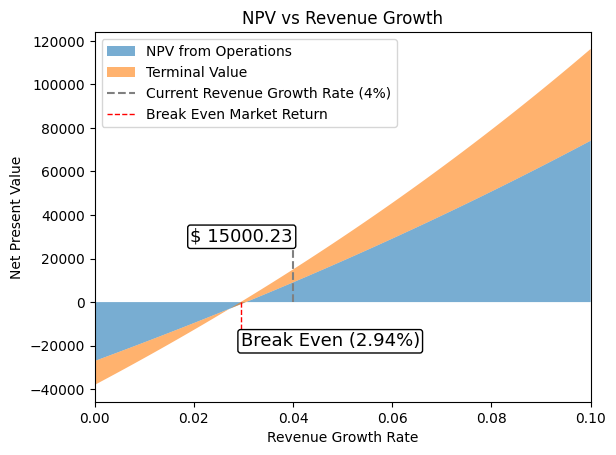

In [150]:
calculate_npvs = np.vectorize(calculate_npv)
min_lim = 0
max_lim = 0.1
revenue_growths = np.linspace(min_lim, max_lim, 100)
npvs = calculate_npvs(revenue_growth=revenue_growths)

# Calculate the stacked values
operations_npv = npvs[0]
terminal_value = npvs[1]

# Specific risk free rate value at 0.04
total_npv_035 = calculate_npv(revenue_growth=0.04)[2]
print(total_npv_035)

# Plot the stacked areas using revenue_growths
plt.fill_between(revenue_growths, 0, operations_npv, label='NPV from Operations', alpha=0.6)
plt.fill_between(revenue_growths, operations_npv, operations_npv + terminal_value, label='Terminal Value', alpha=0.6)

# Add a vertical line at risk_free_rate=0.0304
plt.vlines(x=0.04, ymin=0, ymax=total_npv_035 * 2, color='grey', linestyle='--', label='Current Revenue Growth Rate (4%)')
plt.vlines(x=0.029425, ymin=0, ymax=-1.2*total_npv_035, color='red', linestyle='--', label='Break Even Market Return', linewidth=1)



# Add NPV at current risk free rate value label
plt.text(
    0.04,
    total_npv_035 * 2,
    r"$ " + str(total_npv_035),
    fontsize=13,
    va="center",
    ha="right",
    bbox=dict(
        facecolor="white",
        edgecolor="black",
        boxstyle="round",
        pad=0.15
    ),
    zorder=10  # to make sure the text is on top
)

plt.text(
    0.029425,
    -1.2*total_npv_035,
    "Break Even (2.94%)",
    fontsize=13,
    va="center",
    bbox=dict(
        facecolor="white",
        edgecolor="black",
        boxstyle="round",
        pad=0.15
    ),
    zorder=10 # to make sure the text is on top
)

# Adding labels and title
plt.xlabel('Revenue Growth Rate')
plt.ylabel('Net Present Value')
plt.title('NPV vs Revenue Growth')
plt.legend()

# Set the x-axis limits to match the revenue_growths range
plt.xlim(min_lim, max_lim)

# Show plot
plt.show()
